In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm

import joblib

In [2]:
train = pd.read_csv('train(1).csv')
test = pd.read_csv('test.csv')

In [3]:
#   Drop ID
train = train.drop('id',axis=1)

#   cols to encode:
'Gender','Marital Status','Education Level','Occupation','Location','Policy Type','Customer Feedback','Smoking Status','Exercise Frequency','Property Type'

('Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type')

In [4]:
#   Fill "Occupation" Nulls
train['Occupation'].fillna('Unknown', inplace=True)
test['Occupation'].fillna('Unknown', inplace=True)


C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\501823538.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Occupation'].fillna('Unknown', inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\501823538.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [5]:
#   Strange occurance in "Age", where '41.145563' is the only non whole number. It also has a significant amount of occurances in both train and test.csv
#   - Try rounding
train['Age'].value_counts().sort_index()
train['Age'] = train['Age'].round()
test['Age'] = test['Age'].round()

In [6]:
print(train['Policy Start Date'].min())
print(train['Policy Start Date'].max())
df = train

2019-08-17 15:21:39.080371
2024-08-15 15:21:39.287115


In [7]:
def encode_date(df):
    #   format to datetime datatype
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])

    #  
    df['PSD Year'] = df['Policy Start Date'].dt.year
    df['PSD Month'] = df['Policy Start Date'].dt.month
    df['PSD Day'] = df['Policy Start Date'].dt.day
    df['Quarter'] = df['Policy Start Date'].dt.quarter


    #   Capture cyclical trends for month of the year and day of the month
    df['Month_Sin'] = np.sin(2 * np.pi * df['PSD Month'] / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['PSD Month'] / 12)

    df['Day_Sin'] = np.sin(2 * np.pi * df['PSD Day'] / 31)
    df['Day_Cos'] = np.cos(2 * np.pi * df['PSD Day'] / 31)

    #   Cyclical trends in day of the week. May create unnecessary noise
    df['Day_of_Week_Sin'] = np.sin(2 * np.pi * df['PSD Day'] / 7)
    df['Day_of_Week_Cos'] = np.cos(2 * np.pi * df['PSD Day'] / 7)

    df.drop('Policy Start Date',axis=1,inplace=True)

    return df

train = encode_date(train)
test = encode_date(test)

In [8]:
for i in train.columns:
    print(i)
    print(train[i][1], type(train[i][1]))
    print("~~~~")

#   List of cols that need encoding
#   'Gender','Marital Status','Education Level','Occupation','Location','Policy Type','Customer Feedback','Smoking Status','Exercise Frequency','Property Type'

Age
39.0 <class 'numpy.float64'>
~~~~
Gender
Female <class 'str'>
~~~~
Annual Income
31678.0 <class 'numpy.float64'>
~~~~
Marital Status
Divorced <class 'str'>
~~~~
Number of Dependents
3.0 <class 'numpy.float64'>
~~~~
Education Level
Master's <class 'str'>
~~~~
Occupation
Unknown <class 'str'>
~~~~
Health Score
15.569730989408043 <class 'numpy.float64'>
~~~~
Location
Rural <class 'str'>
~~~~
Policy Type
Comprehensive <class 'str'>
~~~~
Previous Claims
1.0 <class 'numpy.float64'>
~~~~
Vehicle Age
12.0 <class 'numpy.float64'>
~~~~
Credit Score
694.0 <class 'numpy.float64'>
~~~~
Insurance Duration
2.0 <class 'numpy.float64'>
~~~~
Customer Feedback
Average <class 'str'>
~~~~
Smoking Status
Yes <class 'str'>
~~~~
Exercise Frequency
Monthly <class 'str'>
~~~~
Property Type
House <class 'str'>
~~~~
Premium Amount
1483.0 <class 'numpy.float64'>
~~~~
PSD Year
2023 <class 'numpy.int32'>
~~~~
PSD Month
6 <class 'numpy.int32'>
~~~~
PSD Day
12 <class 'numpy.int32'>
~~~~
Quarter
2 <class 'numpy.int

In [9]:
def count_na(df):
    #   Looking at Null Values
    null_counts = df.isnull().sum()
    print(null_counts)
count_na(train)

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation                   0
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
PSD Year                     0
PSD Month                    0
PSD Day                      0
Quarter                      0
Month_Sin                    0
Month_Cos                    0
Day_Sin                      0
Day_Cos                      0
Day_of_Week_Sin              0
Day_of_Week_Cos              0
dtype: int64


<Axes: xlabel='Age', ylabel='Count'>

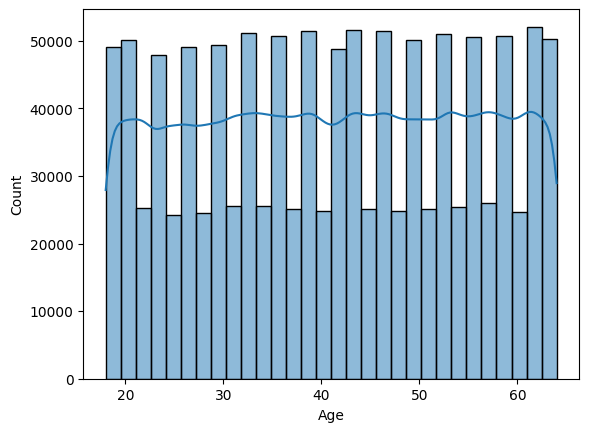

In [10]:
#   Age
sns.histplot(train['Age'].dropna(), kde=True, bins=30)

In [11]:
#   Age seems to follow a relatively uniform distribution. We will use the mean age in place of missing values.
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(train['Age'].mean(), inplace=True)

C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1398659185.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].mean(), inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1398659185.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

<Axes: xlabel='Annual Income', ylabel='Count'>

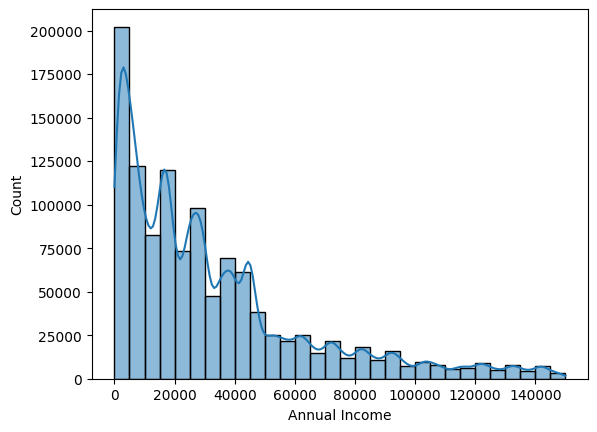

In [12]:
#   Now looking at annual income
sns.histplot(train['Annual Income'].dropna(), kde=True, bins=30)

In [13]:
#   Grouping by Occupation, median Annual Income has little disparity.
#   Same for grouping by Education Level
print(train.groupby('Occupation')['Annual Income'].median())
print(train.groupby('Education Level')['Annual Income'].median())

#   Because of this, we will stick to simplicity and use general median
train['Annual Income'].fillna(train['Annual Income'].median(), inplace=True)
test['Annual Income'].fillna(train['Annual Income'].median(), inplace=True)

Occupation
Employed         23961.0
Self-Employed    23961.0
Unemployed       23962.0
Unknown          23890.0
Name: Annual Income, dtype: float64
Education Level
Bachelor's     23862.0
High School    23961.0
Master's       23952.0
PhD            23981.0
Name: Annual Income, dtype: float64


C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\4036374252.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Annual Income'].fillna(train['Annual Income'].median(), inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\4036374252.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [14]:
#   Very low NA counts, just drop the rows
train = train.dropna(subset=['Vehicle Age','Insurance Duration'])
test['Vehicle Age'] = test['Vehicle Age'].fillna(test['Vehicle Age'].mean())
test['Insurance Duration'] = test['Insurance Duration'].fillna(test['Insurance Duration'].median())

In [15]:
#   Marital Status
print(train['Marital Status'].value_counts())
print(test['Marital Status'].value_counts())

train['Marital Status'].fillna('Unknown', inplace=True)
test['Marital Status'].fillna('Unknown', inplace=True)

Marital Status
Single      395389
Married     394313
Divorced    391762
Name: count, dtype: int64
Marital Status
Single      263705
Married     262172
Divorced    261787
Name: count, dtype: int64


C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1398423210.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Marital Status'].fillna('Unknown', inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1398423210.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Marital Status'].fillna('Unknown', inplace=True)
C:\User

In [16]:
#   Number of Dependents
#       Replace with -1 category for missing values
train['Number of Dependents'].fillna(-1, inplace=True)
test['Number of Dependents'].fillna(-1, inplace=True)

C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1383665051.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Number of Dependents'].fillna(-1, inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1383665051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Number of Dependents'].fillna(-1, inplace=True)
C:\Users\

25.613937457837746 24.57871778980782


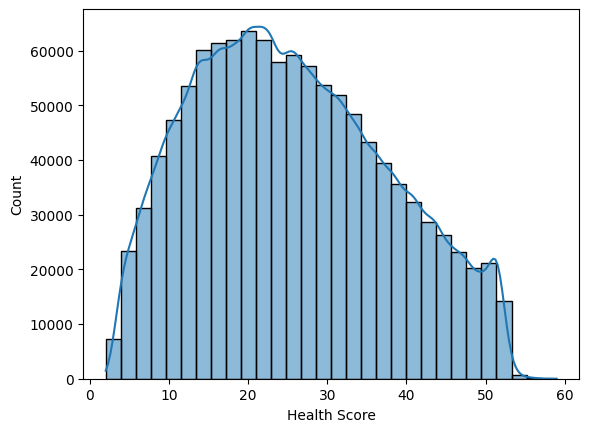

In [17]:
#   Health Score
sns.histplot(train['Health Score'].dropna(), kde=True, bins=30)
print(train['Health Score'].mean(),train['Health Score'].median())

In [18]:
#   Check for correlation between Smoking Status, Exercise Frequency, Health Score before deciding on how to handle missing values
temple = LabelEncoder()
temp = train[['Smoking Status','Exercise Frequency','Health Score']]
temp.dropna(inplace=True)
temp['Smoking Status'] = temple.fit_transform(temp['Smoking Status'])
temp['Exercise Frequency'] = temple.fit_transform(temp['Exercise Frequency'])


C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\2450266611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.dropna(inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\2450266611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Smoking Status'] = temple.fit_transform(temp['Smoking Status'])
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\2450266611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [19]:
print(temp[['Smoking Status', 'Exercise Frequency', 'Health Score']].corr())

                    Smoking Status  Exercise Frequency  Health Score
Smoking Status            1.000000            0.001779     -0.002053
Exercise Frequency        0.001779            1.000000     -0.000831
Health Score             -0.002053           -0.000831      1.000000


In [20]:
#   No Correlation. Just use median health score
train['Health Score'].fillna(train['Health Score'].median(), inplace=True)
test['Health Score'].fillna(train['Health Score'].median(), inplace=True)

C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\3649251331.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Health Score'].fillna(train['Health Score'].median(), inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\3649251331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Health Score'].fillna(train['Health S

In [21]:
#   Previous Claims
#       new category, -1
train['Previous Claims'].fillna(-1, inplace=True)
test['Previous Claims'].fillna(-1, inplace=True)

C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1628008439.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Previous Claims'].fillna(-1, inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1628008439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Previous Claims'].fillna(-1, inplace=True)
C:\Users\Chohb\AppD

In [22]:
#   Credit Score
train['Customer Feedback'].fillna('Unknown',inplace=True)
test['Customer Feedback'].fillna('Unknown',inplace=True)

C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1311514639.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Customer Feedback'].fillna('Unknown',inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\1311514639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Customer Feedback'].fillna('Unknown',inplace=True)
C:\

<Axes: xlabel='Credit Score', ylabel='Count'>

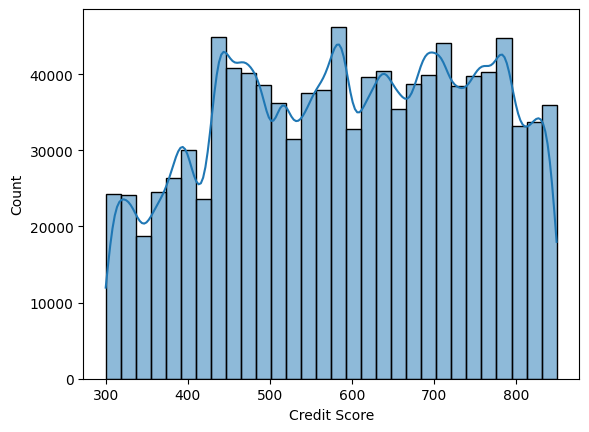

In [23]:
#   Credit Score
sns.histplot(train['Credit Score'].dropna(), kde=True, bins=30)

In [24]:
train['Credit Score'].fillna(train['Credit Score'].median(),inplace=True)
test['Credit Score'].fillna(train['Credit Score'].median(),inplace=True)

C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\2855959947.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Credit Score'].fillna(train['Credit Score'].median(),inplace=True)
C:\Users\Chohb\AppData\Local\Temp\ipykernel_11192\2855959947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Credit Score'].fillna(train['Credit Sc

In [25]:
#   Now that all missing values are accounted for, encode everything
#       This may be temporary encoding to find correlations between variables. May leave most encoding to LightGBM if used.

#   Ordinal Encoding:
#   'Education Level','Policy Type','Insurance Duration','Exercise Frequency','Customer Feedback (unknown = -1)'


#   One Hot Encoding
#   'Gender','Marital Status','Occupation','Location','Unknown Customer Feedback','Smoking Status','Property Type'

train['Customer Feedback'].value_counts()

Customer Feedback
Average    377903
Poor       375514
Good       368752
Unknown     77824
Name: count, dtype: int64

In [26]:
#   Use temp df to encode and analyze relations between variables.
temp = train.copy()

#   Ordinal
ordinal_cols = ['Education Level','Policy Type','Exercise Frequency']
order = [
            ["High School","Bachelor's","Master's","PhD"],
            ["Basic","Premium","Comprehensive"],
            ["Rarely","Monthly","Weekly","Daily"]
        ]
encoder = OrdinalEncoder(categories=order)
temp[ordinal_cols] = encoder.fit_transform(temp[ordinal_cols])

#   One Hot (For temp, we will just use label encoding to find relationships)
oh_cols = ['Gender','Marital Status','Occupation','Location','Smoking Status','Property Type']
encoder = LabelEncoder()
for col in oh_cols:
    temp[col] = encoder.fit_transform(temp[col])

#   Special case of 'Customer Feedback', where ordinality is apparent, however 6% of values are missing and replaced with 'unknown'.
#       Simply doing ordinal encoding would not capture the unknown values correctly. Thus, set unknown to -1, with a new binary encoded column to check for unknown customer feedback!
# Define ordinal order
cf_ordinal_order = ['Poor', 'Average', 'Good']

#   Binary column for 'Unknown'
temp['Customer Feedback Unknown'] = (temp['Customer Feedback'] == 'Unknown').astype(int)

#   turn unknown back to NA, for simple fill
temp['Customer Feedback'] = temp['Customer Feedback'].replace('Unknown',pd.NA)

encoder = OrdinalEncoder(categories=[cf_ordinal_order], handle_unknown='use_encoded_value', unknown_value=-1)
temp['Customer Feedback'] = encoder.fit_transform(temp[['Customer Feedback']])

#   Move response to end
resp = temp.pop('Premium Amount')
temp.insert(len(temp.columns),resp.name,resp)

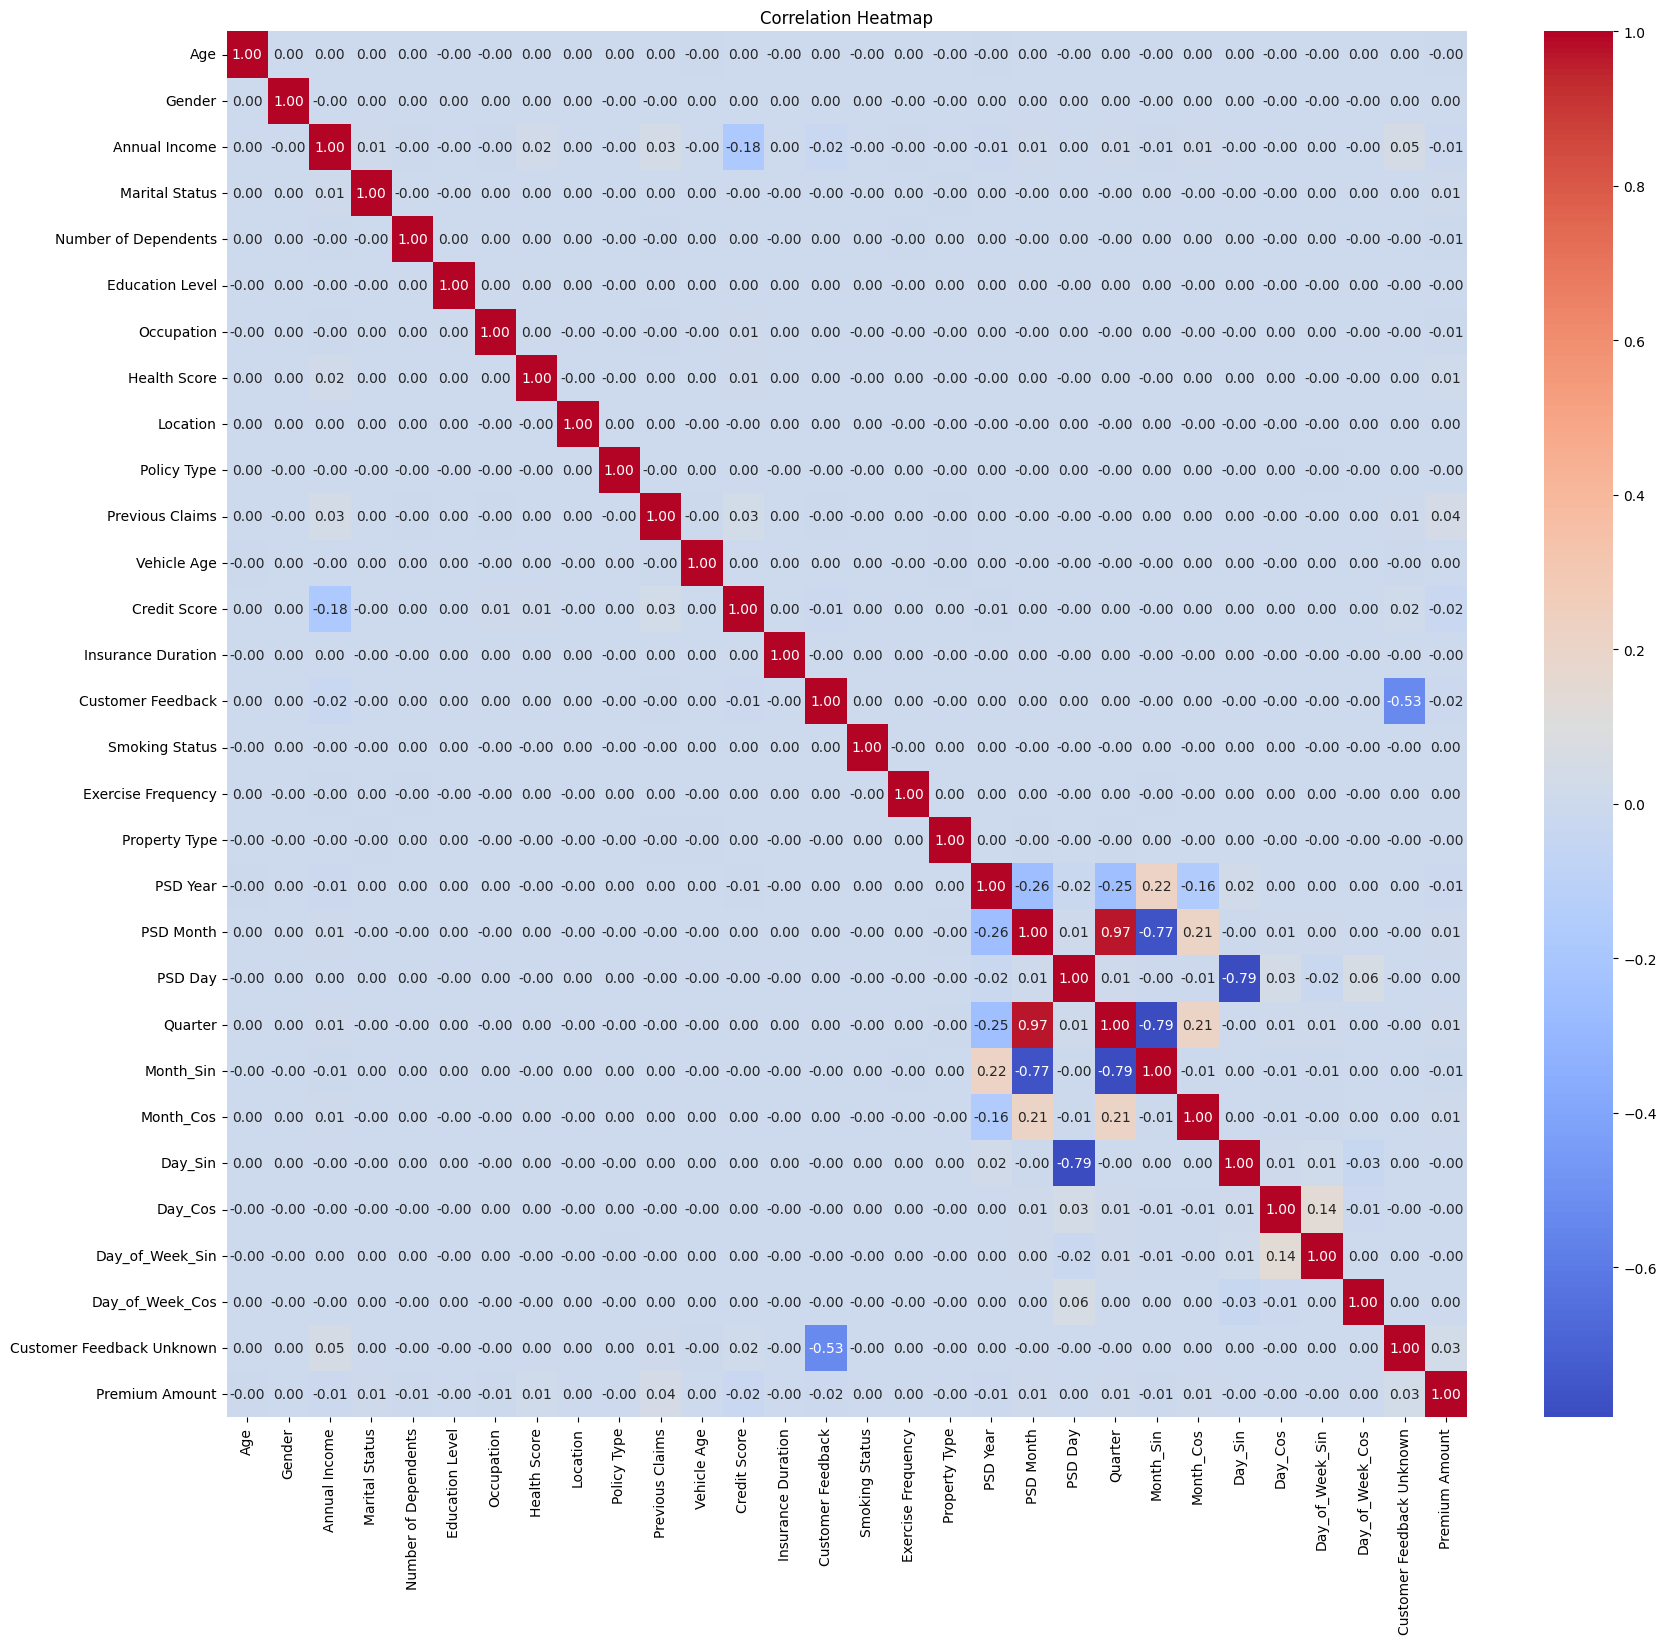

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Heatmap
corr = temp.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

<Axes: xlabel='Premium Amount', ylabel='Count'>

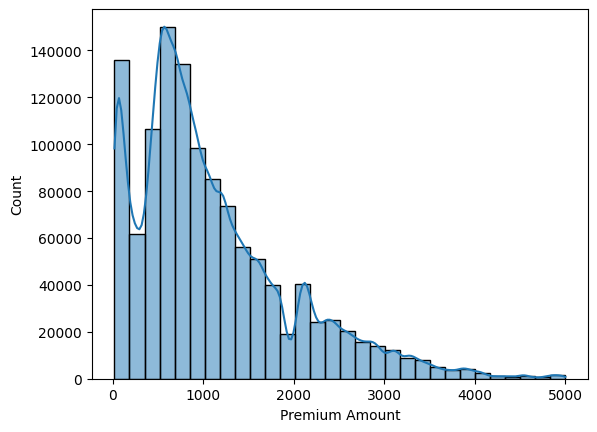

In [28]:
sns.histplot(temp['Premium Amount'], kde=True, bins=30)

In [29]:
train.to_csv('train_cleaned.csv', index=False)
test.to_csv('test_cleaned.csv', index=False)


In [30]:
#   To redo the training process
#   START HERE
#   Output; train2,test2

train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')

def encode_it(train_df, test_df):
    # Ordinal Encoding
    ordinal_cols = ['Education Level', 'Policy Type', 'Exercise Frequency']
    order = [
        ["High School", "Bachelor's", "Master's", "PhD"],
        ["Basic", "Premium", "Comprehensive"],
        ["Rarely", "Monthly", "Weekly", "Daily"]
    ]
    encoder = OrdinalEncoder(categories=order)
    train_df[ordinal_cols] = encoder.fit_transform(train_df[ordinal_cols])
    test_df[ordinal_cols] = encoder.transform(test_df[ordinal_cols])

    # Label Encoding (consistent across train and test)
    cat_cols = ['Gender', 'Marital Status', 'Occupation', 
                'Location', 'Smoking Status', 'Property Type']
    
    # Fit LabelEncoders on combined unique categories
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        combined_values = pd.concat([train_df[col], test_df[col]]).dropna().unique()
        le.fit(combined_values)  # Fit on all unique values
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        label_encoders[col] = le  # Store the encoder for later use

    # Special case for 'Customer Feedback'
    cf_ordinal_order = ['Poor', 'Average', 'Good']
    train_df['Customer Feedback Unknown'] = (train_df['Customer Feedback'] == 'Unknown').astype(int)
    test_df['Customer Feedback Unknown'] = (test_df['Customer Feedback'] == 'Unknown').astype(int)

    train_df['Customer Feedback'] = train_df['Customer Feedback'].replace('Unknown', pd.NA)
    test_df['Customer Feedback'] = test_df['Customer Feedback'].replace('Unknown', pd.NA)

    encoder = OrdinalEncoder(categories=[cf_ordinal_order], handle_unknown='use_encoded_value', unknown_value=-1)
    train_df['Customer Feedback'] = encoder.fit_transform(train_df[['Customer Feedback']])
    test_df['Customer Feedback'] = encoder.transform(test_df[['Customer Feedback']])

    return train_df, test_df, label_encoders

# Use the function
train2, test2, label_encoders = encode_it(train.copy(), test.copy())

# Move response column to the end
resp = train2.pop('Premium Amount')
train2.insert(len(train2.columns), resp.name, resp)


In [31]:
#   Going back for feature engineering

#   Annual Income x Previous Claims
#   Hypothesis: Higher Income individuals with more Previous Claims will lead to higher Premium Amounts
#       - Feature alone is not useful.
#       - Log transformation is not useful.
#       - Binary Indicator for high Income x Claims values to suppliment this featue; not useful.
#   Reject hypothesis.
'''
train2['Income x Claims'] = train2['Annual Income'] * train2['Previous Claims']

high_threshold = train2['Income x Claims'].quantile(0.9)
train2['High_Income_Claims'] = (train2['Income x Claims'] > high_threshold).astype(int)
'''

#   Health Score x Credit Score
#   Note: For Health Score, higher is healthier. (VIA SHAP graph)
#   Hypothesis: Higher Health Score and Credit Score will lead to lower Premium Amounts
#       - Feature alone produced same error as baseline.
#       - Log transformation increased error.
#   Reject hypothesis.
'''
train2['Health x Credit'] = train2['Health Score'] * train2['Credit Score']
train2['Health x Credit'] = np.log1p(train2['Health x Credit'])
'''

#   Credit Score x Annual Income
#   Hypothesis: Higher Credit Score on a high income individual will lead to lower premiums, as opposed to low credit score 
#       - Feature alone produced higher error than baseline.
#       - Log transformation increased error despite accounting for large skew.
#   Reject hypothesis.
'''
train2['Credit x Income'] = train2['Credit Score'] * train2['Annual Income']
train2['Credit x Income'] = np.log1p(train2['Credit x Income'])
'''

#   Credit / Income
#   Hypothesis: Credit Score relative to income will impact premiums.
#    - Feature alone produced higher error than baseline. However, the distribution is wild. Large outliers.
#    - Log transformation slightly reduced error!
#    - Binning and Capping quartiles did not help.
#   Hypothesis accepted.
train2['Credit / Income'] = train2['Credit Score'] / train2['Annual Income']
train2['Credit / Income'] = np.log1p(train2['Credit / Income'])
test2['Credit / Income'] = test2['Credit Score'] / test2['Annual Income']



<Axes: xlabel='Credit / Income', ylabel='Count'>

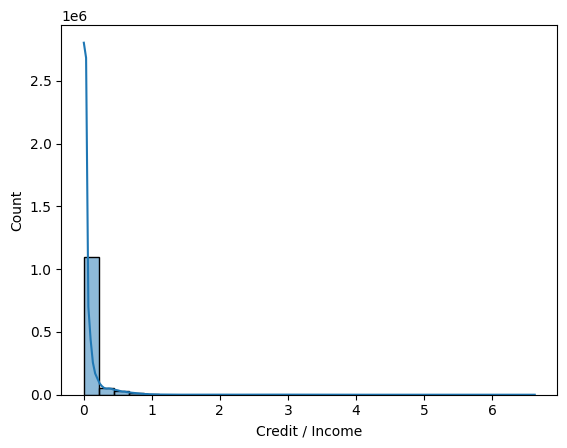

In [32]:
#   'Annual Income' highly right skewed. Log transformation necessary
#       No change to error
sns.histplot(train2['Credit / Income'].dropna(), kde=True,bins=30)

In [33]:
X = train2.drop(columns=['Premium Amount'])
Y = train2['Premium Amount']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

In [34]:
#       Find best parameters

# Define parameter grid (reduced ranges)

param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9], 
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'lambda': [1],
    'alpha': [1],
}

model = xgb.XGBRegressor(random_state=69)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='neg_mean_squared_log_error',
    cv=3,
    random_state=42,
)

random_search.fit(X_train, y_train)
print("Best Parameters: ", random_search.best_params_)
print("Best Accuracy: ", -random_search.best_score_)
#Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 0.1, 'colsample_bytree': 1.0, 'alpha': 1}



c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_

Best Parameters:  {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'lambda': 1, 'gamma': 0.5, 'colsample_bytree': 0.8, 'alpha': 1}
Best Accuracy:  1.2894657244904026


<Axes: xlabel='Premium Amount', ylabel='Count'>

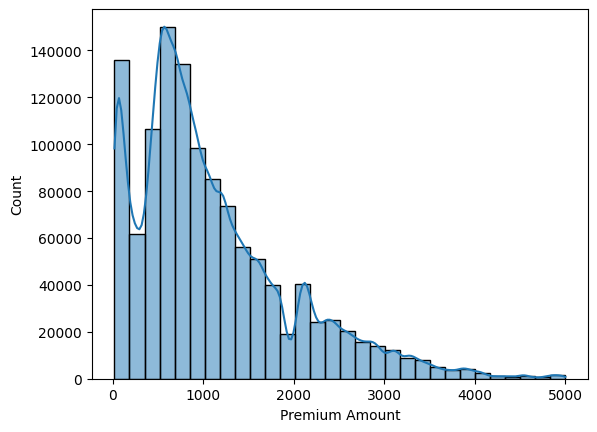

In [35]:
sns.histplot(train2['Premium Amount'].dropna(), kde=True, bins=30)

In [36]:
#   Response variable seems heavily skewed. Try log transformation
y_train_log = np.log1p(y_train)  # log(1 + y) to avoid log(0)
y_test_log = np.log1p(y_test)


In [38]:
model = xgb.XGBRegressor(**random_search.best_params_)
model.fit(X_train, y_train_log)

y_pred = model.predict(X_test)
y_pred_original = np.expm1(y_pred)  # Reverse log transformation

rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_original))
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle:.4f}")


Root Mean Squared Logarithmic Error (RMSLE): 1.0472


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

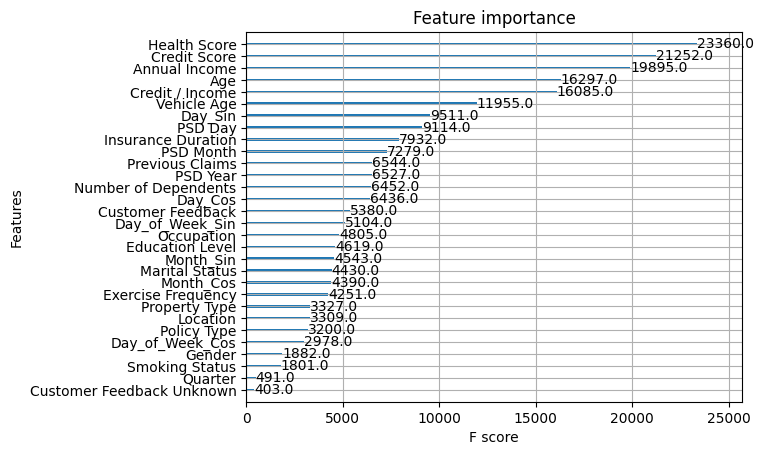

In [39]:
# Feature Importance (Optional)
xgb.plot_importance(model)

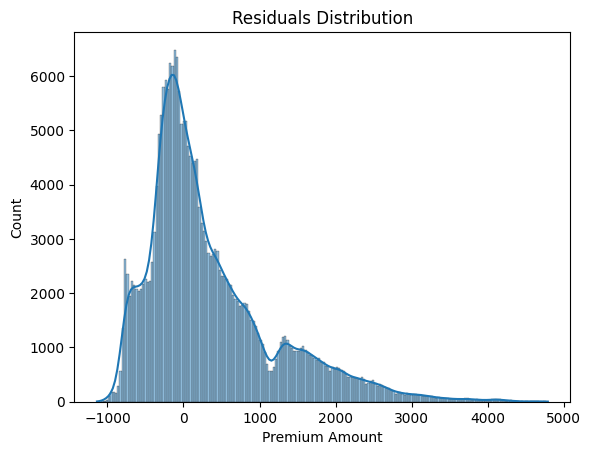

In [40]:
residuals = y_test - y_pred_original

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

In [ ]:
#   From the graph of the residuals, we can get more context on the efficacy of the model.
#       - The residuals are centered around 0, which is a good sign. The model is not consistently over or under predicting the target variable.
#       - Normally distributed residuals are a good sign, indicating that the model is capturing the underlying patterns in the data.
#       - The right skew indicates that the model is underpredicting. For higher premiums, it is harder for the model to predict accurately.